In [1]:
import math
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.transforms as T
import geopandas as gpd
import pandas as pd
import momepy
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=False)

from utils.utils import remove_item
from utils.load_geodata import load_graph
from prediction import run, load_data
from utils.constants import *
!nvidia-smi

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Tue Jun  7 23:25:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   25C    P8     5W / 180W |   2520MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
result_dict = torch.load('meridian_model_runs.pt')

In [ ]:
place = 'No Bounds'
model_dict = {}
result_dict = {}


for var_args in [
    'minmax',
    'maxabs',
    'robust',
    'power',
    'sum'
]:  
    data_process_args = {
        'scaler': var_args,
        'clean': False,
        'include_feats': unnorm_feature_fields,
        'split_approach': 'neighbor', 
        'batch_size':  4096 ,
    }
    model_args = {
        'model_type': 'sage',
        'num_layers': 2,
        'aggr': 'min',
        'hidden_channels': 20
    }
    print(f'Testing {var_args}')
    models, results = run(place, target_field='meridian_class',
                          data_process_args=data_process_args,
                          model_args=model_args,
                          early_stopping=False,
                          epochs=50,
                          schedule_lr=True,
                          lr=0.01,
                          num_iter=5)
    model_dict[str(var_args)] = models
    result_dict[str(var_args)] = results

In [2]:
place = remove_item(included_places, inductive_places)
result_dict = {}
for var_args in  [
    {'model_type': 'mlp', 'num_layers': 3},
    {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'},
]:
        data_process_args = {
            'split_approach': 'cluster',
            'num_parts': 512,
            'batch_size': 16,
            'include_feats': all_feature_fields,
            'categorize': 'multiclass',
            'clean': True,
            'agg': 'min'
        }
        model_args = {
            **var_args,
            'hidden_channels': 20,
        }
        print(f'Testing {var_args}')
        models, results = run(place,
                              inductive_place=inductive_places,
                              target_field='accident_count',
                              data_process_args=data_process_args,
                              model_args=model_args,
                              lr=0.01,
                              schedule_lr=True,
                              criteria_names=['Accuracy', 'MAE', 'MSE', 'RMSE'],
                              num_iter=5)
        result_dict[str(var_args)] = results
# torch.save(result_dict, 'accident_pred_model_runs.pt')

Testing {'model_type': 'mlp', 'num_layers': 3}
Loading graph of ['Isle of Wight', 'Wycombe', 'Enfield', 'Slough', 'South Bucks', 'Hillingdon', 'Ealing', 'Chiltern', 'Copeland', 'Windsor and Maidenhead', 'Plymouth', 'South Hams', 'Oxford', 'Waltham Forest', 'Mendip', 'Dudley', 'Cotswold', 'Erewash', 'Redbridge', 'Epping Forest', 'Test Valley', 'Basingstoke and Deane', 'South Gloucestershire', 'Woking', 'Broxbourne', 'Wolverhampton', 'Wiltshire', 'Swindon', 'Bath and North East Somerset', 'Trafford', 'Salford', 'South Staffordshire', 'West Oxfordshire', 'Malvern Hills', 'Vale of White Horse', 'South Kesteven', 'North Kesteven', 'Guildford', 'Southwark', 'Chichester', 'Waverley', 'Elmbridge', 'Forest of Dean', 'Tewkesbury', 'Charnwood', 'Sheffield', 'Ashfield', 'North West Leicestershire', 'North East Derbyshire', 'Stroud', 'Shropshire', 'Telford and Wrekin', 'Horsham', 'City of London', 'Newcastle-under-Lyme', 'Stafford', 'Stoke-on-Trent', 'Arun', 'Lichfield', 'Sandwell', 'Birmingham', '

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 1.029s)
Loading graph data for inductive testing...
Loading graph of ['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale'] with key ("['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale']", "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']", 'accident_count', 'dual', True, 'min', True, 50, False)...
Reading SSx OpenMapping dataset, this may take a while...
Constructing SSx-Accident dataset, this may take a while...
Combining gdfs of ['Sevenoaks', 'Tonbridge 

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 0.213s)
Val Metrics when predicting all == 0:
Accuracy: 0.722 MAE: 0.541 MSE: 1.387 RMSE: 1.178
Inductive:
Metrics when predicting all == 0:
Accuracy: 0.679 MAE: 0.649 MSE: 1.714 RMSE: 1.309
Starting iteration 1 with model {'model_type': 'mlp', 'num_layers': 3, 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1304 params)
Epoch 001 (3.34s/epoch): Train Loss: 1.543, Val Loss: 1.123, Accuracy: 0.722, MAE: 0.445, MSE: 0.910, RMSE: 0.936
Epoch 002 (3.03s/epoch): Train Loss: 1.093, Val Loss: 1.053, Accuracy: 0.728, MAE: 0.432, MSE: 0.882, RMSE: 0.925
Epoch 003 (3.08s/epoch): Train Loss: 1.049, Val Loss: 1.022, Accuracy: 0.729, MAE: 0.426, MSE: 0.853, RMSE: 0.910
Epoch 004 (3.04s/epoch): Train Loss: 1.027, Val Loss: 1.010, Accuracy: 0.721, MAE: 0.422, MSE: 0.809, RMSE: 0.886
Epoch 005 (3.02s/epoch): Train Loss: 1.014, Val Loss: 0.995, Accuracy: 0.720, MAE: 0.421, MSE: 0.798, RMSE: 0.881
Epoch 006 (3.08s/epoch): T

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.969058,0.957264,0.711714,0.411485,0.72922,0.843113


Starting iteration 2 with model {'model_type': 'mlp', 'num_layers': 3, 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1304 params)
Epoch 001 (3.03s/epoch): Train Loss: 1.441, Val Loss: 1.177, Accuracy: 0.707, MAE: 0.461, MSE: 0.914, RMSE: 0.942
Epoch 002 (3.01s/epoch): Train Loss: 1.080, Val Loss: 1.044, Accuracy: 0.728, MAE: 0.429, MSE: 0.867, RMSE: 0.918
Epoch 003 (2.93s/epoch): Train Loss: 1.038, Val Loss: 1.014, Accuracy: 0.728, MAE: 0.424, MSE: 0.838, RMSE: 0.902
Epoch 004 (2.91s/epoch): Train Loss: 1.018, Val Loss: 1.017, Accuracy: 0.718, MAE: 0.430, MSE: 0.833, RMSE: 0.901
Epoch 005 (3.02s/epoch): Train Loss: 1.006, Val Loss: 0.991, Accuracy: 0.719, MAE: 0.420, MSE: 0.789, RMSE: 0.876
Epoch 006 (3.09s/epoch): Train Loss: 1.011, Val Loss: 0.984, Accuracy: 0.721, MAE: 0.420, MSE: 0.797, RMSE: 0.878
Epoch 007 (3.01s/epoch): Train Loss: 0.996, Val Loss: 0.981, Accuracy: 0.712, MAE: 0.417, MSE: 0.752, RMSE: 0.856
Epoch 008 (2.97s/epoch): Train Loss: 0.992, Val Loss: 0.

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.966385,0.959006,0.711347,0.412167,0.730821,0.844164


Starting iteration 3 with model {'model_type': 'mlp', 'num_layers': 3, 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1304 params)
Epoch 001 (3.07s/epoch): Train Loss: 1.501, Val Loss: 1.190, Accuracy: 0.706, MAE: 0.453, MSE: 0.879, RMSE: 0.927
Epoch 002 (2.99s/epoch): Train Loss: 1.078, Val Loss: 1.066, Accuracy: 0.724, MAE: 0.440, MSE: 0.901, RMSE: 0.939
Epoch 003 (2.99s/epoch): Train Loss: 1.043, Val Loss: 1.023, Accuracy: 0.726, MAE: 0.430, MSE: 0.860, RMSE: 0.915
Epoch 004 (2.96s/epoch): Train Loss: 1.020, Val Loss: 1.004, Accuracy: 0.722, MAE: 0.423, MSE: 0.816, RMSE: 0.892
Epoch 005 (2.99s/epoch): Train Loss: 1.012, Val Loss: 0.999, Accuracy: 0.717, MAE: 0.419, MSE: 0.781, RMSE: 0.873
Epoch 006 (3.00s/epoch): Train Loss: 1.002, Val Loss: 0.980, Accuracy: 0.721, MAE: 0.418, MSE: 0.788, RMSE: 0.873
Epoch 007 (3.06s/epoch): Train Loss: 0.992, Val Loss: 0.980, Accuracy: 0.716, MAE: 0.418, MSE: 0.773, RMSE: 0.868
Epoch 008 (3.01s/epoch): Train Loss: 0.987, Val Loss: 0.

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.968652,0.959399,0.713336,0.412105,0.737444,0.847359


Starting iteration 4 with model {'model_type': 'mlp', 'num_layers': 3, 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1304 params)
Epoch 001 (2.97s/epoch): Train Loss: 1.451, Val Loss: 1.170, Accuracy: 0.703, MAE: 0.445, MSE: 0.821, RMSE: 0.892
Epoch 002 (2.97s/epoch): Train Loss: 1.092, Val Loss: 1.066, Accuracy: 0.717, MAE: 0.440, MSE: 0.853, RMSE: 0.906
Epoch 003 (2.99s/epoch): Train Loss: 1.054, Val Loss: 1.030, Accuracy: 0.716, MAE: 0.435, MSE: 0.832, RMSE: 0.893
Epoch 004 (3.03s/epoch): Train Loss: 1.036, Val Loss: 1.023, Accuracy: 0.721, MAE: 0.444, MSE: 0.893, RMSE: 0.923
Epoch 005 (3.00s/epoch): Train Loss: 1.020, Val Loss: 1.001, Accuracy: 0.710, MAE: 0.431, MSE: 0.790, RMSE: 0.873
Epoch 006 (3.02s/epoch): Train Loss: 1.010, Val Loss: 1.001, Accuracy: 0.702, MAE: 0.433, MSE: 0.766, RMSE: 0.862
Epoch 007 (2.99s/epoch): Train Loss: 1.006, Val Loss: 0.994, Accuracy: 0.716, MAE: 0.428, MSE: 0.810, RMSE: 0.883
Epoch 008 (3.06s/epoch): Train Loss: 1.002, Val Loss: 0.

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.968231,0.961241,0.707055,0.415545,0.730667,0.843383


Starting iteration 5 with model {'model_type': 'mlp', 'num_layers': 3, 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1304 params)
Epoch 001 (2.99s/epoch): Train Loss: 1.534, Val Loss: 1.171, Accuracy: 0.709, MAE: 0.456, MSE: 0.898, RMSE: 0.935
Epoch 002 (2.95s/epoch): Train Loss: 1.083, Val Loss: 1.049, Accuracy: 0.731, MAE: 0.434, MSE: 0.897, RMSE: 0.933
Epoch 003 (2.94s/epoch): Train Loss: 1.048, Val Loss: 1.021, Accuracy: 0.730, MAE: 0.425, MSE: 0.854, RMSE: 0.910
Epoch 004 (2.96s/epoch): Train Loss: 1.026, Val Loss: 1.005, Accuracy: 0.726, MAE: 0.423, MSE: 0.833, RMSE: 0.896
Epoch 005 (2.95s/epoch): Train Loss: 1.011, Val Loss: 0.993, Accuracy: 0.725, MAE: 0.421, MSE: 0.817, RMSE: 0.888
Epoch 006 (2.99s/epoch): Train Loss: 1.000, Val Loss: 0.990, Accuracy: 0.715, MAE: 0.419, MSE: 0.772, RMSE: 0.867
Epoch 007 (3.02s/epoch): Train Loss: 0.997, Val Loss: 0.987, Accuracy: 0.711, MAE: 0.418, MSE: 0.755, RMSE: 0.858
Epoch 008 (2.98s/epoch): Train Loss: 1.001, Val Loss: 0.

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.966964,0.959406,0.711451,0.413025,0.734737,0.845831


Testing {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}
Loading graph of ['Isle of Wight', 'Wycombe', 'Enfield', 'Slough', 'South Bucks', 'Hillingdon', 'Ealing', 'Chiltern', 'Copeland', 'Windsor and Maidenhead', 'Plymouth', 'South Hams', 'Oxford', 'Waltham Forest', 'Mendip', 'Dudley', 'Cotswold', 'Erewash', 'Redbridge', 'Epping Forest', 'Test Valley', 'Basingstoke and Deane', 'South Gloucestershire', 'Woking', 'Broxbourne', 'Wolverhampton', 'Wiltshire', 'Swindon', 'Bath and North East Somerset', 'Trafford', 'Salford', 'South Staffordshire', 'West Oxfordshire', 'Malvern Hills', 'Vale of White Horse', 'South Kesteven', 'North Kesteven', 'Guildford', 'Southwark', 'Chichester', 'Waverley', 'Elmbridge', 'Forest of Dean', 'Tewkesbury', 'Charnwood', 'Sheffield', 'Ashfield', 'North West Leicestershire', 'North East Derbyshire', 'Stroud', 'Shropshire', 'Telford and Wrekin', 'Horsham', 'City of London', 'Newcastle-under-Lyme', 'Stafford', 'Stoke-on-Trent', 'Arun', 'Lichfield', 'Sandwell',

Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 0.938s)
Loading graph data for inductive testing...
Loading graph of ['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale'] with key ("['Sevenoaks', 'Tonbridge and Malling', 'Dartford', 'Gravesham', 'Medway', 'Tunbridge Wells', 'Maidstone', 'Canterbury', 'Ashford', 'Thanet', 'Dover', 'Swale']", "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'meridian_class']", 'accident_count', 'dual', True, 'min', True, 50, False)...
Loaded graph from cache.
Categorizing accident_count
Classifying accident_count


Computing METIS partitioning...
Done!


Cluster Loader with 512 clusters, 16 graphs per batch (Time taken: 0.211s)
Val Metrics when predicting all == 0:
Accuracy: 0.722 MAE: 0.541 MSE: 1.387 RMSE: 1.178
Inductive:
Metrics when predicting all == 0:
Accuracy: 0.679 MAE: 0.649 MSE: 1.714 RMSE: 1.309
Starting iteration 1 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1544 params)
Epoch 001 (3.09s/epoch): Train Loss: 1.517, Val Loss: 1.176, Accuracy: 0.721, MAE: 0.491, MSE: 1.128, RMSE: 1.034
Epoch 002 (3.03s/epoch): Train Loss: 1.125, Val Loss: 1.082, Accuracy: 0.715, MAE: 0.442, MSE: 0.871, RMSE: 0.921
Epoch 003 (3.05s/epoch): Train Loss: 1.059, Val Loss: 1.031, Accuracy: 0.723, MAE: 0.435, MSE: 0.872, RMSE: 0.915
Epoch 004 (3.04s/epoch): Train Loss: 1.024, Val Loss: 1.008, Accuracy: 0.710, MAE: 0.421, MSE: 0.765, RMSE: 0.863
Epoch 005 (3.05s/epoch): Train Loss: 0.996, Val Loss: 0.982, Accuracy: 0.721, MAE: 0.419, MSE: 0.791, RMSE: 0.875
Epoch 006 

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.941903,0.939712,0.712964,0.405627,0.707897,0.830512


Starting iteration 2 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1544 params)
Epoch 001 (3.00s/epoch): Train Loss: 1.523, Val Loss: 1.206, Accuracy: 0.701, MAE: 0.486, MSE: 1.008, RMSE: 0.983
Epoch 002 (3.04s/epoch): Train Loss: 1.156, Val Loss: 1.115, Accuracy: 0.717, MAE: 0.474, MSE: 1.016, RMSE: 0.989
Epoch 003 (3.04s/epoch): Train Loss: 1.084, Val Loss: 1.055, Accuracy: 0.709, MAE: 0.442, MSE: 0.844, RMSE: 0.899
Epoch 004 (3.03s/epoch): Train Loss: 1.047, Val Loss: 1.035, Accuracy: 0.701, MAE: 0.436, MSE: 0.790, RMSE: 0.876
Epoch 005 (3.14s/epoch): Train Loss: 1.027, Val Loss: 1.009, Accuracy: 0.710, MAE: 0.433, MSE: 0.806, RMSE: 0.879
Epoch 006 (2.99s/epoch): Train Loss: 1.013, Val Loss: 1.001, Accuracy: 0.697, MAE: 0.428, MSE: 0.741, RMSE: 0.849
Epoch 007 (3.09s/epoch): Train Loss: 1.015, Val Loss: 1.041, Accuracy: 0.720, MAE: 0.446, MSE: 0.899, RMSE: 0.927
Epoch 008 (3.06s/epoch): Train Loss: 1.0

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.947211,0.945272,0.71018,0.40897,0.711518,0.832719


Starting iteration 3 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1544 params)
Epoch 001 (3.05s/epoch): Train Loss: 1.762, Val Loss: 1.222, Accuracy: 0.709, MAE: 0.483, MSE: 1.037, RMSE: 0.994
Epoch 002 (3.00s/epoch): Train Loss: 1.153, Val Loss: 1.101, Accuracy: 0.720, MAE: 0.446, MSE: 0.916, RMSE: 0.944
Epoch 003 (2.91s/epoch): Train Loss: 1.071, Val Loss: 1.045, Accuracy: 0.719, MAE: 0.434, MSE: 0.854, RMSE: 0.912
Epoch 004 (3.01s/epoch): Train Loss: 1.029, Val Loss: 1.006, Accuracy: 0.722, MAE: 0.420, MSE: 0.801, RMSE: 0.881
Epoch 005 (3.08s/epoch): Train Loss: 1.004, Val Loss: 0.993, Accuracy: 0.719, MAE: 0.420, MSE: 0.790, RMSE: 0.872
Epoch 006 (2.99s/epoch): Train Loss: 0.998, Val Loss: 1.008, Accuracy: 0.722, MAE: 0.440, MSE: 0.884, RMSE: 0.918
Epoch 007 (3.03s/epoch): Train Loss: 0.999, Val Loss: 0.978, Accuracy: 0.720, MAE: 0.420, MSE: 0.789, RMSE: 0.872
Epoch 008 (3.05s/epoch): Train Loss: 0.9

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.939594,0.937332,0.712236,0.405204,0.704053,0.828635


Starting iteration 4 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1544 params)
Epoch 001 (3.05s/epoch): Train Loss: 1.524, Val Loss: 1.213, Accuracy: 0.696, MAE: 0.492, MSE: 1.014, RMSE: 0.994
Epoch 002 (2.97s/epoch): Train Loss: 1.147, Val Loss: 1.073, Accuracy: 0.723, MAE: 0.444, MSE: 0.911, RMSE: 0.940
Epoch 003 (3.10s/epoch): Train Loss: 1.059, Val Loss: 1.033, Accuracy: 0.720, MAE: 0.433, MSE: 0.850, RMSE: 0.910
Epoch 004 (3.03s/epoch): Train Loss: 1.023, Val Loss: 1.009, Accuracy: 0.716, MAE: 0.426, MSE: 0.807, RMSE: 0.888
Epoch 005 (3.03s/epoch): Train Loss: 1.003, Val Loss: 0.986, Accuracy: 0.718, MAE: 0.420, MSE: 0.788, RMSE: 0.875
Epoch 006 (3.02s/epoch): Train Loss: 0.992, Val Loss: 0.998, Accuracy: 0.701, MAE: 0.423, MSE: 0.738, RMSE: 0.849
Epoch 007 (3.02s/epoch): Train Loss: 0.980, Val Loss: 0.971, Accuracy: 0.709, MAE: 0.415, MSE: 0.735, RMSE: 0.846
Epoch 008 (3.01s/epoch): Train Loss: 0.9

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.94667,0.944176,0.712055,0.408122,0.715289,0.834551


Starting iteration 5 with model {'model_type': 'sage', 'num_layers': 2, 'aggr': 'max', 'hidden_channels': 20, 'in_channels': 17, 'out_channels': 5} (1544 params)
Epoch 001 (3.04s/epoch): Train Loss: 1.577, Val Loss: 1.233, Accuracy: 0.693, MAE: 0.503, MSE: 1.058, RMSE: 1.008
Epoch 002 (3.09s/epoch): Train Loss: 1.156, Val Loss: 1.092, Accuracy: 0.715, MAE: 0.445, MSE: 0.884, RMSE: 0.925
Epoch 003 (2.98s/epoch): Train Loss: 1.077, Val Loss: 1.041, Accuracy: 0.717, MAE: 0.432, MSE: 0.833, RMSE: 0.899
Epoch 004 (3.01s/epoch): Train Loss: 1.032, Val Loss: 1.011, Accuracy: 0.719, MAE: 0.426, MSE: 0.819, RMSE: 0.891
Epoch 005 (3.04s/epoch): Train Loss: 1.008, Val Loss: 0.990, Accuracy: 0.714, MAE: 0.419, MSE: 0.769, RMSE: 0.865
Epoch 006 (3.09s/epoch): Train Loss: 0.998, Val Loss: 0.987, Accuracy: 0.713, MAE: 0.420, MSE: 0.770, RMSE: 0.867
Epoch 007 (3.00s/epoch): Train Loss: 0.990, Val Loss: 0.972, Accuracy: 0.711, MAE: 0.416, MSE: 0.746, RMSE: 0.851
Epoch 008 (3.05s/epoch): Train Loss: 0.9

,Train Loss,Val Loss,Accuracy,MAE,MSE,RMSE
0,0.935917,0.933197,0.713527,0.40307,0.698821,0.825993


In [4]:
from numbers import Number
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
records = []
for model in result_dict:
    for iter_res in result_dict[model]:
        metrics = {}
        for key in iter_res:
            if not isinstance(iter_res[key], Number) and len(iter_res[key]) > 0:
                metrics[key] = iter_res[key][-1]
            else:
                metrics[key] = iter_res[key]
        # metrics = {
        #     key: iter_res[key][-1]
        #     for key in iter_res
        #     if len(iter_res[key]) > 0 and key != 'total_loss'
        # }
        
        records.append({ 'model': model, **metrics })
result_df = pd.DataFrame.from_records(records)
result_df[['model', 'MAE', 'RMSE', 'Inductive MAE', 'Inductive RMSE']]

/tmp/ipykernel_2393705/1104327311.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,model,MAE,RMSE,Inductive MAE,Inductive RMSE
0,"{'model_type': 'mlp', 'num_layers': 3}",0.411485,0.843113,0.474911,0.928298
1,"{'model_type': 'mlp', 'num_layers': 3}",0.412167,0.844164,0.473208,0.926535
2,"{'model_type': 'mlp', 'num_layers': 3}",0.412105,0.847359,0.474154,0.930635
3,"{'model_type': 'mlp', 'num_layers': 3}",0.415545,0.843383,0.479755,0.931997
4,"{'model_type': 'mlp', 'num_layers': 3}",0.413025,0.845831,0.469992,0.924085
5,"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}",0.405627,0.830512,0.468364,0.919492
6,"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}",0.408970,0.832719,0.474949,0.924083
7,"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}",0.405204,0.828635,0.471013,0.922849
8,"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}",0.408122,0.834551,0.467646,0.915708
9,"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'max'}",0.403070,0.825993,0.470597,0.921819


{"{'model_type': 'sage', 'num_layers': 2, 'aggr': 'min'}": [GraphSAGE(10, 4, num_layers=2), GraphSAGE(10, 4, num_layers=2), GraphSAGE(10, 4, num_layers=2), GraphSAGE(10, 4, num_layers=2), GraphSAGE(10, 4, num_layers=2)], "{'model_type': 'mlp', 'num_layers': 3}": [MyMLP(10, 20, 20, 4), MyMLP(10, 20, 20, 4), MyMLP(10, 20, 20, 4), MyMLP(10, 20, 20, 4), MyMLP(10, 20, 20, 4)]}
Loading graph of Cambridge with key ('Cambridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", 'meridian_class', 'dual', False, 'sum', True, 50, False)...
Loaded graph from cache.
Encoded meridian_class into the following classes: ['aroad' 'broad' 'minor' 'motorway']
No split_approach specified, defaulting to full batch...
Loading graph of Coventry with key ('Coventry', "[

/tmp/ipykernel_1461521/2721830588.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


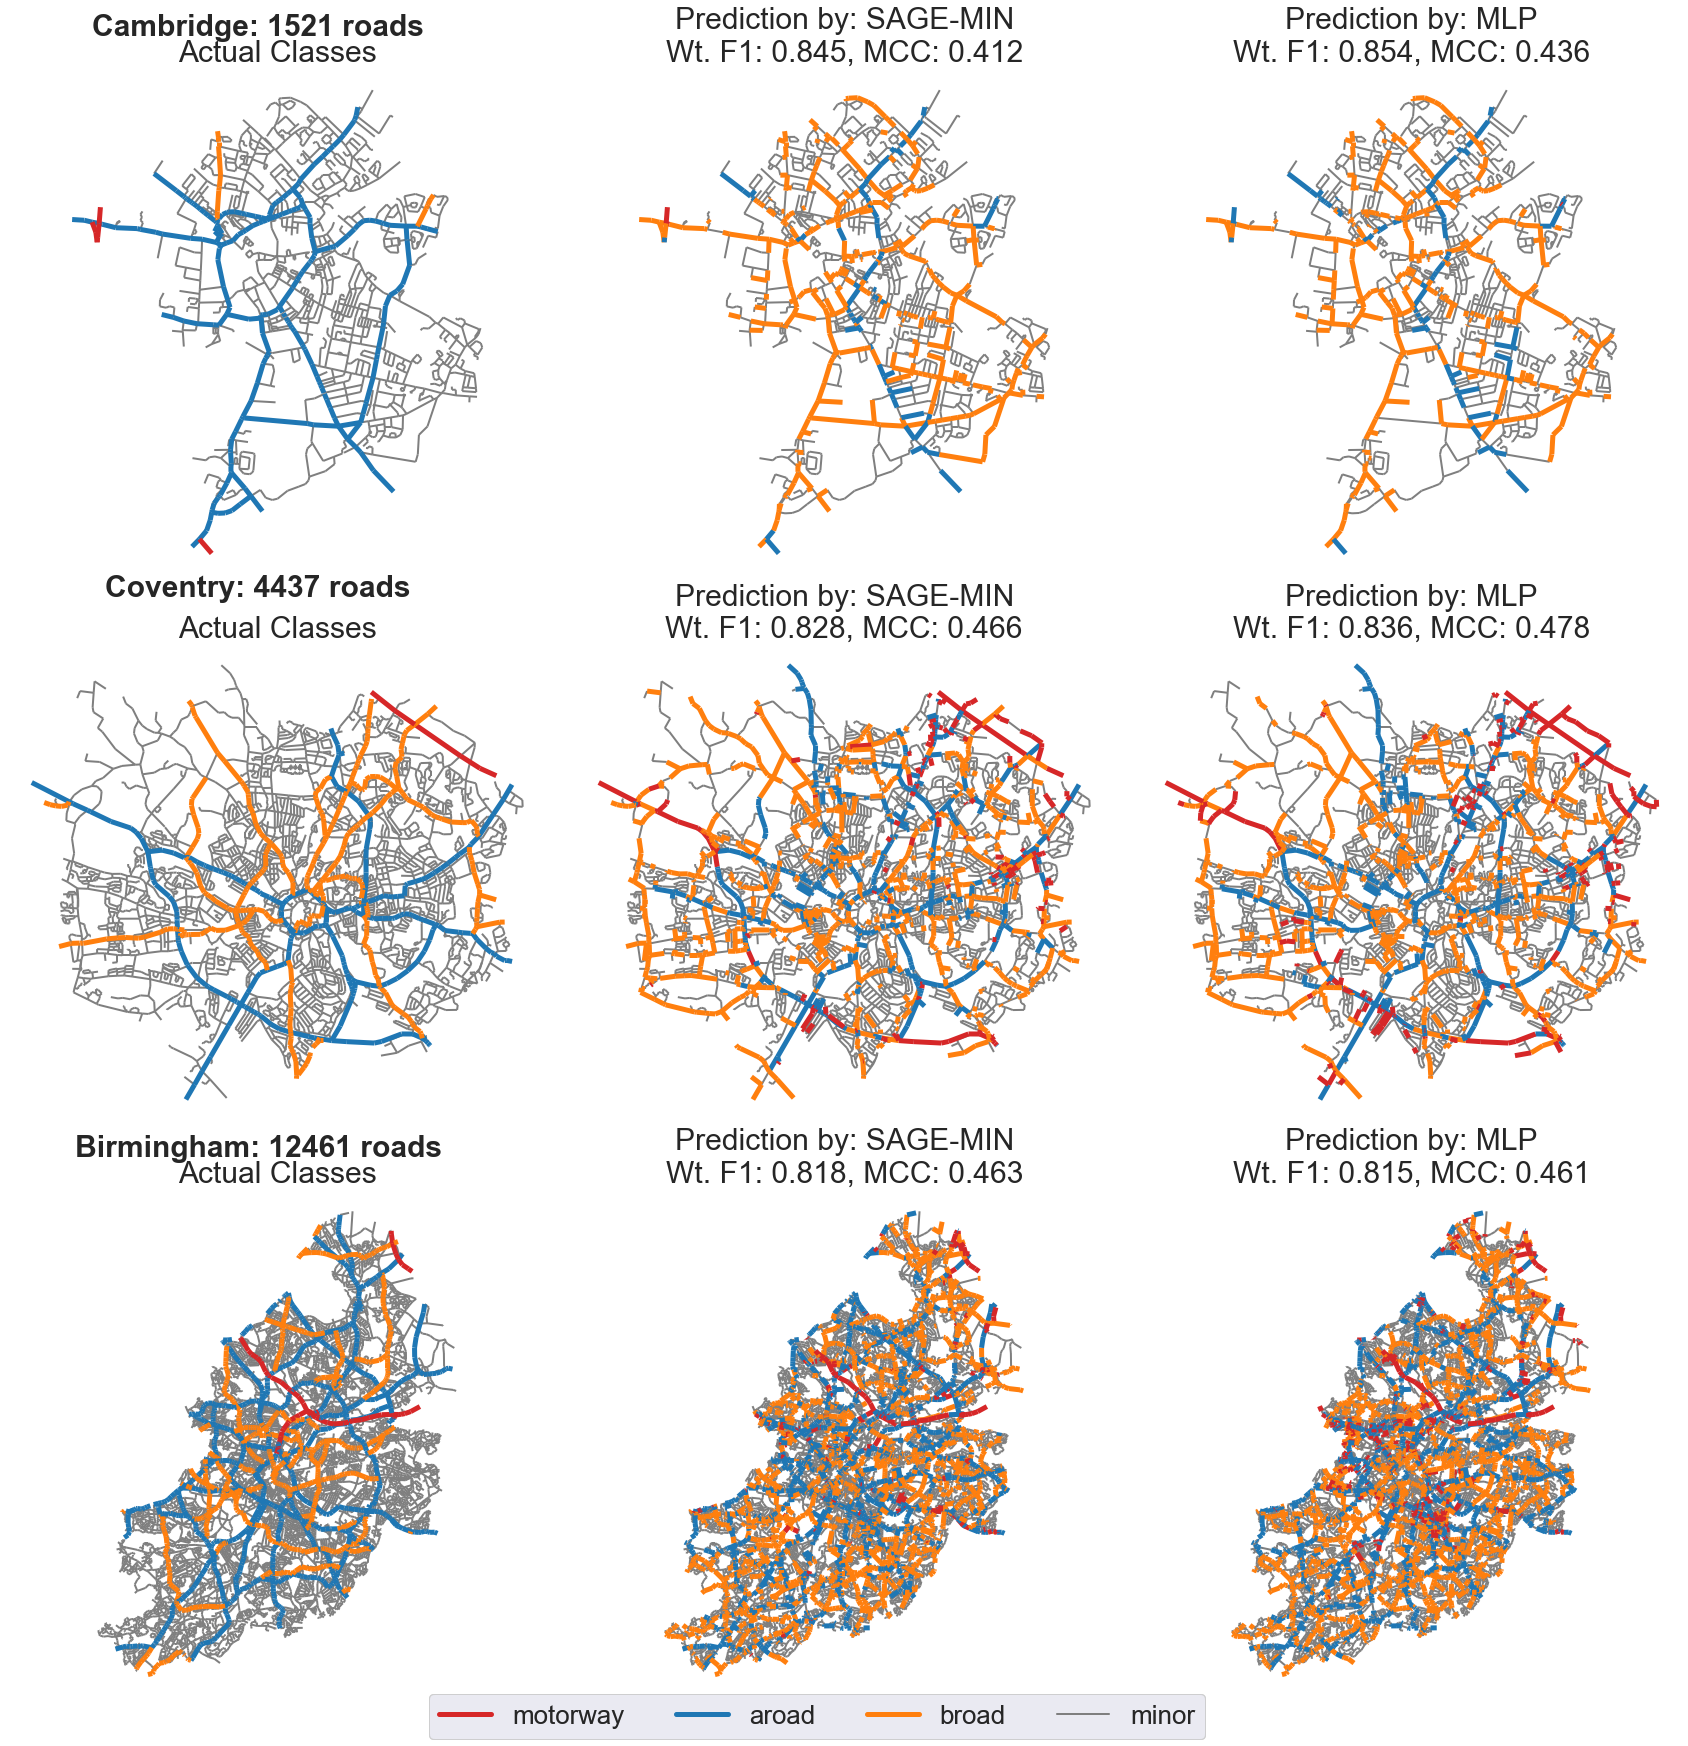

In [41]:
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef 
import pylab
import matplotlib.gridspec as gridspec


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
color_dict = {'motorway': '#d62728',
              'aroad': '#1f77b4',
              'broad': '#ff7f0e',
              'minor': '#7f7f7f'}

custom_lines = [Line2D([0], [0], color=col, lw=lw) for col, lw in zip(list(color_dict.values()), [5, 5, 5, 2])]

def visualize_preds(places, models, model_titles=None,
                    only_pred=False, target_field = 'meridian_class'):
    clean = target_field == 'meridian_class'
    num_plots = len(models) + 1
    
    f = plt.figure(figsize=(num_plots*10, 10*len(places)))
    outer = gridspec.GridSpec(len(places), 1, wspace=0.1, hspace=0.1)
    for i, place in enumerate(places):
        data, _, _ = load_data(place, target_field,
                           include_feats=unnorm_feature_fields,
                            clean=clean,
                            verbose=True)

        streets = load_graph(place, target_field=target_field,
                            feature_fields=all_feature_fields,
                             force_connected=True,
                             clean=clean,
                            return_nx=True)
        
        inner = gridspec.GridSpecFromSubplotSpec(1,num_plots,
                    subplot_spec=outer[i], wspace=0.05, hspace=0.05)    
        ax = plt.Subplot(f, outer[i])
        ax.set_title(f'{place}: {streets.number_of_nodes()} roads', fontsize=30, fontweight="bold", y=1.05, x=0.15)
        ax.axis('off')
        f.add_subplot(ax)

        # Convert nx graph to dgl (preserves node order) and get model predictions 
        data = data.to(device)
        mcc, f1 = [], []
        for idx, model in enumerate(models):
            preds = model(data.x.float(), data.edge_index)

            # Convert preds to label and assign to nx nodes
            pred_dict = {}
            pred_classes = []
            for i, e in enumerate(streets.edges()):
                pred = preds[i].argmax().item()
                pred_classes.append(pred)
                pred_dict[e] = data.classes[int(pred)]
            nx.set_edge_attributes(streets, pred_dict, f'preds_model_{idx + 1}')

            # Obtain metrics
            mcc.append(matthews_corrcoef(data.y.cpu(), np.array(pred_classes)))
            f1.append(f1_score(data.y.cpu(), np.array(pred_classes), average='weighted'))

        # Convert nx graph back to gdf
        lines = momepy.nx_to_gdf(streets)[1]

         # plot actual and predicted values
        # f, ax = plt.subplots(1, num_plots, figsize=(num_plots*10, 10), sharex=True, sharey=True)
        target_fields = [target_field] + [f'preds_model_{idx + 1}' for idx in range(len(models))]
        for idx, field in enumerate(target_fields):
            ax = plt.Subplot(f, inner[idx])
        
            minor_lines = lines[lines[field] == 'minor']
            other_lines = lines[lines[field] != 'minor']
            for g, lw, z in [(minor_lines, 2, 1), (other_lines, 5, 2)]:
                colors = [color_dict[cat] for cat in g[field]]
                g.plot(ax=ax, column=field, colors=colors, linewidth=lw, zorder=z)
            
            if idx == 0:
                subtitle = 'Actual Classes'
            else:
                idx = idx - 1
                subtitle = f'Prediction by: {model_titles[idx]}\n' \
                     f'Wt. F1: {f1[idx]:.3f}, MCC: {mcc[idx]:.3f}'
            ax.set_title(subtitle, size=30)
            ax.axis("off")
            f.add_subplot(ax)
        
        f.legend(custom_lines, list(color_dict.keys()),
                 loc='lower center', bbox_to_anchor=(0.5, 0.1), fontsize='x-large', ncol=4)
        # plt.suptitle(title, fontweight="bold", fontsize=40, x=0.2, y=0.98)

places = ['Cambridge', 'Coventry', 'Birmingham']
model_titles = ['SAGE-MIN', 'MLP']
print(model_dict)
sns.set(font_scale=1.5)
models = [model_dict[model_type][0] for model_type in model_dict]
visualize_preds(places, models, model_titles=model_titles, target_field='meridian_class')
plt.tight_layout()
plt.savefig('meridian_pred.png')

In [1]:

!jupyter nbconvert --to script predicting-classes.ipynb

[NbConvertApp] Converting notebook predicting-classes.ipynb to script
[NbConvertApp] Writing 13230 bytes to predicting-classes.py
